In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import util


In [3]:
"""
Load frequency discrimination thresholds. This cell requires `eval.csv` files
in the model directories to re-calculate model thresholds or `results.csv` files
in the model directories to load previously calculated model thresholds.
"""

# list_dir_model = glob.glob("models/freq_all/IHC????/arch_*") # Models optimized for full frequency range
list_dir_model = glob.glob("models/freq_quarter_octave/*hz/*IHC????/arch_*") # Models optimized separately for each quarter octave

# The `experiment` object generates `results.csv` files containing frequency discrimination
# thresholds in each model directory or loads them to a dataframe if they already exist
experiment = util.ExperimentHeinz2001FrequencyDiscrimination(overwrite=0, verbose=0)
df = experiment(list_dir_model)

def combine_dir_model(dir_model):
    """
    Assigns the same model directory to all frequency-specific models for plotting
    """
    dir_model = [_ for _ in dir_model.split("/") if ("hz" not in _) and ("arch" not in _)]
    dir_model = os.path.join(*dir_model)
    return dir_model

df_human = pd.read_csv("data/heinz_etal_2001_fig4a_frequency_discrimination_thresholds.csv")
df = pd.concat([df, df_human.rename(columns={"model": "dir_model"})])
df.f0 = df.f0.astype(np.float32)
df = df[~df["dir_model"].str.contains("human")] # Exclude human data to simplify figure
df = df[df.f0 <= 8e3] # Exclude frequencies for which the model CF range influenced results (as in Heinz et al. 2001)
df["dir_model"] = df["dir_model"].map(combine_dir_model)
df = df.drop(columns=["fn_eval", "log_threshold", "threshold"])
df = df.groupby(["dir_model", "f0"]).agg({"weber_fraction": list}).reset_index()


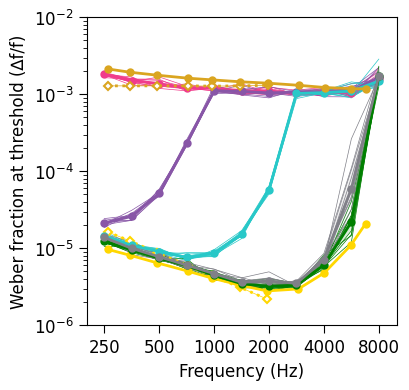

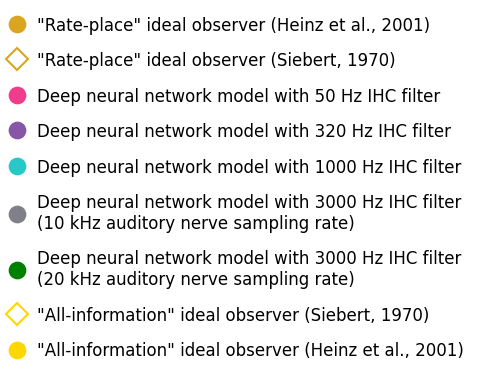

In [4]:
def get_color_and_label_from_dir_model(dir_model):
    """
    Specifies color and legend label for each model directory
    """
    if "human" in dir_model.lower():
        color = "k"
        label = "Human listeners (Moore, 1973)"
    elif "all_information_analytical" in dir_model.lower():
        color = "gold"
        label = '"All-information" ideal observer (Siebert, 1970)'
    elif "rate_place_analytical" in dir_model.lower():
        color = "goldenrod"
        label = '"Rate-place" ideal observer (Siebert, 1970)'
    elif "all_information_computational" in dir_model.lower():
        color = "gold"
        label = '"All-information" ideal observer (Heinz et al., 2001)'
    elif "rate_place_computational" in dir_model.lower():
        color = "goldenrod"
        label = '"Rate-place" ideal observer (Heinz et al., 2001)'
    elif "ihc3000" in dir_model.lower():
        color = "#808088"
        label = "Deep neural network model with 3000 Hz IHC filter"
    elif "ihc1000" in dir_model.lower():
        color = "#28C8C8"
        label = "Deep neural network model with 1000 Hz IHC filter"
    elif "ihc0320" in dir_model.lower():
        color = "#8856a7"
        label = "Deep neural network model with 320 Hz IHC filter"
    elif "ihc0050" in dir_model.lower():
        color = "#F03C8C"
        label = "Deep neural network model with 50 Hz IHC filter"
    else:
        color = None
        label = os.path.basename(os.path.dirname(dir_model))
    return color, label


fig, ax = plt.subplots(figsize=(4, 4))
legend_sort_values = []
for dir_model in sorted(df.dir_model.unique()):
    dfi = df[df.dir_model == dir_model]
    x = dfi.f0.values
    yarr = np.array(list(dfi.weber_fraction.values))
    log_yarr = np.log(yarr)
    log_yarr_mean = np.mean(log_yarr, axis=1)
    log_yarr_sem = np.std(log_yarr, axis=1) / np.sqrt(log_yarr.shape[1])
    y = np.exp(log_yarr_mean)
    legend_sort_values.append(y.mean())
    color, label = get_color_and_label_from_dir_model(dir_model)
    if any(["sr10000_IHC3000" in _ for _ in df.dir_model.unique()]):
        # For supplementary figure comparing 10 vs 20 kHz nervegram sampling rate
        if "sr10000_IHC3000" in dir_model:
            label += "\n(10 kHz auditory nerve sampling rate)"
            color = "#808088"
        elif "IHC3000" in dir_model:
            label += "\n(20 kHz auditory nerve sampling rate)"
            color = "g"
    kwargs_plot = {
        "marker":  "D" if "analytical" in dir_model else "o",
        "ms": 4.5,
        "lw": 2,
        "mew": 1.5,
        "label": label,
        "color": color,
        "ls": ":" if "analytical" in dir_model else "-",
        "mfc": "w" if "analytical" in dir_model else None,
    }
    ax.fill_between(
        x,
        np.exp(log_yarr_mean - 2 * log_yarr_sem),
        np.exp(log_yarr_mean + 2 * log_yarr_sem),
        alpha=0.15,
        facecolor=kwargs_plot["color"],
    )
    ax.plot(x, y, **kwargs_plot)
    ax.plot(x, yarr, lw=0.5, color=kwargs_plot["color"], zorder=-1)
util.format_axes(
    ax,
    yscale="log",
    xscale="log",
    ylimits=[1e-6, 1e-2],
    xticks=[250, 500, 1000, 2000, 4000, 8000],
    xticks_minor=[],
    xticklabels=[250, 500, 1000, 2000, 4000, 8000],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Weber fraction at threshold (∆f/f)",
    xlimits=[250 * 4/5, 8e3 * 5/4],
)
plt.show()

# fn = "../phaselocknet/figures_revision1/results_frequency_discrimination.pdf"
# if any(["sr10000_IHC3000" in _ for _ in df.dir_model.unique()]):
#     fn = "../phaselocknet/figures_revision1/results_frequency_discrimination_sample_rate.pdf"
# fig.savefig(fn, bbox_inches="tight", pad_inches=0.05, transparent=True)
# print(fn)


fig_legend, ax_legend = plt.subplots(figsize=(4, 4))
handles, labels = ax.get_legend_handles_labels()
idx_sort = np.argsort(legend_sort_values)[::-1]
kwargs_legend = {
    "fontsize": 12,
    "markerscale": 2,
    "handlelength": 0,
    "frameon": False,
    "loc": "center",
    "handletextpad": 1.25,
    "labelspacing": 1.05,
    "markerscale": 2.5,
}
ax_legend.legend(
    [handles[_] for _ in idx_sort],
    [labels[_] for _ in idx_sort],
    **kwargs_legend,
)
util.format_axes(
    ax_legend,
    spines_to_hide=["top", "bottom", "left", "right"],
    xticks=[],
    yticks=[],
)
plt.show()

# fn = fn.replace(".pdf", "_legend.pdf")
# fig_legend.savefig(fn, bbox_inches="tight", pad_inches=0.05, transparent=True)
# print(fn)


In [5]:
"""
Calculating DNN model frequency discrimination thresholds from `eval.csv` files,
which contain individual model judgments for evaluation dataset trials.
"""
dir_model = "models/freq_quarter_octave/*hz/IHC3000/arch_0346_0000"
# dir_model = "models/freq_all/IHC3000/arch_0346_0000"

list_fn_eval = [os.path.join(_, "eval.csv") for _ in glob.glob(dir_model)]
df = pd.concat([pd.read_csv(_) for _ in list_fn_eval])

df["correct"] = df["label"] == (df["logits"] > 0)
df["interval"] = np.abs(df["interval"])
df = (
    df.groupby(["f0", "interval"])
    .agg({"correct": "mean"})
    .reset_index()
)
df = df.sort_values(by=["f0", "interval"])
df = (
    df.groupby(["f0"])
    .agg({"interval": list, "correct": list})
    .reset_index()
)
kw = {"method": "dogbox", "max_nfev": 10000}
df["popt"] = df.apply(
    lambda _: util.fit_logistic_function(np.log(_["interval"]), _["correct"], **kw)[0],
    axis=1,
)
df["log_threshold"] = df["popt"].map(lambda _: util.logistic_function_inv(0.75, *_))
df["threshold"] = np.exp(df["log_threshold"])
df


,f0,interval,correct,popt,log_threshold,threshold
0,250.000000,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.526, 0.492, 0.534, 0.546, 0.592, 0.688, 0.8...","[-10.873372643710045, 1.8047609217387344]",-10.873373,0.000019
1,353.553391,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.488, 0.532, 0.504, 0.6, 0.642, 0.758, 0.898...","[-11.243186473591914, 1.6155334715952754]",-11.243186,0.000013
2,500.000000,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.5, 0.508, 0.592, 0.548, 0.674, 0.814, 0.97,...","[-11.457773790503396, 1.8944375338180905]",-11.457774,0.000011
3,707.106781,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.5, 0.532, 0.528, 0.56, 0.686, 0.808, 0.968,...","[-11.461057443274456, 1.9105521560900265]",-11.461057,0.000011
4,1000.000000,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.53, 0.54, 0.61, 0.67, 0.778, 0.93, 1.0, 1.0...","[-12.102906141495517, 1.5224230485457586]",-12.102906,0.000006
5,1414.213562,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.498, 0.574, 0.608, 0.66, 0.794, 0.964, 1.0,...","[-12.1520226194403, 1.6356515750736944]",-12.152023,0.000005
6,2000.000000,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.512, 0.536, 0.622, 0.734, 0.858, 0.984, 1.0...","[-12.428536663137558, 1.7460739770000617]",-12.428537,0.000004
7,2828.427125,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.534, 0.526, 0.59, 0.68, 0.834, 0.96, 1.0, 1...","[-12.215155199295445, 1.8258779642011664]",-12.215155,0.000005
8,4000.000000,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.52, 0.52, 0.568, 0.636, 0.674, 0.874, 0.996...","[-11.685867349859416, 1.7217267694159217]",-11.685867,0.000008
9,5656.854249,"[4.76837158203125e-07, 9.5367431640625e-07, 1....","[0.542, 0.512, 0.556, 0.538, 0.586, 0.71, 0.80...","[-10.734126205407767, 1.0380276124141743]",-10.734126,0.000022


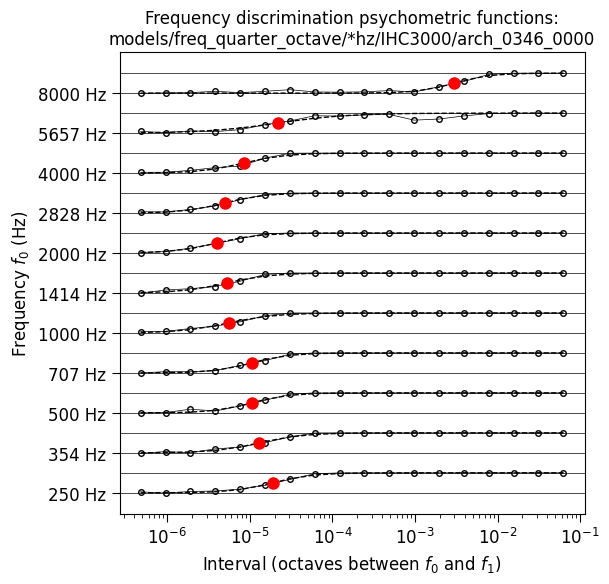

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
yticks = []
yticklabels = []
for itr, f0 in enumerate(df.f0.unique()):
    dfi = df[df.f0 == f0].iloc[0]
    x = np.array(dfi.interval)
    y = np.array(dfi.correct)
    ax.plot(
        x,
        y + itr,
        color="k",
        marker="o",
        mfc="none",
        ms=4,
        lw=0.5,
    )
    ax.plot(
        x,
        util.logistic_function(np.log(x), *dfi.popt) + itr,
        color="k",
        marker="",
        lw=1,
        ls="--",
    )
    ax.plot(
        dfi.threshold,
        0.75 + itr,
        color="r",
        marker="o",
        ms=8,
    )
    ax.axhline(itr + 0.5, color="k", lw=0.5)
    ax.axhline(itr + 1.0, color="k", lw=0.5)
    yticks.append(itr + 0.5)
    yticklabels.append("{:.0f} Hz".format(f0))
util.format_axes(
    ax,
    xscale="log",
    yticks=yticks,
    yticklabels=yticklabels,
    str_xlabel="Interval (octaves between $f_0$ and $f_1$)",
    str_ylabel="Frequency $f_0$ (Hz)",
    str_title="Frequency discrimination psychometric functions:\n{}".format(dir_model),
)
plt.show()


In [21]:
"""
Minimal example of loading and running a model.
"""
import json
import torch
import run_model
import util_torch
import pure_tone_dataset
import peripheral_model

dir_model = "models/freq_all/IHC3000/arch_0346_0000"

with open(os.path.join(dir_model, "config.json"), "r") as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json"), "r") as f:
    architecture = json.load(f)

model = run_model.Model(
    config_model=config_model,
    architecture=architecture,
)

util_torch.load_model_checkpoint(
    model.perceptual_model,
    dir_model,
    map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)
print(model)


[load_model_checkpoint] models/freq_all/IHC3000/arch_0346_0000/ckpt_BEST.pt
Model(
  (peripheral_model): PeripheralModel(
    (gammatone_filterbank): GammatoneFilterbank(
      (fbs): ModuleList(
        (0-3): 4 x IIRFilterbank()
      )
    )
    (ihc_nonlinearity): IHCNonlinearity()
    (ihc_lowpassfilter): IHCLowpassFilter()
    (neural_adaptation): NeuralAdaptation()
  )
  (perceptual_model): PerceptualModel(
    (body): Sequential(
      (conv_0): CustomPaddedConv2d(2, 32, kernel_size=(3, 53), stride=(1, 1))
      (relu_0): ReLU()
      (pool_0): HanningPooling()
      (batch_norm_0): SyncBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): CustomPaddedConv2d(32, 64, kernel_size=(1, 60), stride=(1, 1))
      (relu_1): ReLU()
      (pool_1): HanningPooling()
      (batch_norm_1): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): CustomPaddedConv2d(64, 128, kernel_size=(3, 46), stride=(1, 1))
 

In [22]:
torch.manual_seed(1)
dataset = pure_tone_dataset.Dataset()
example = dataset[0]
x = torch.stack([
    example.pop("x0"),
    example.pop("x1"),
])
model.eval()

print("Trial metadata:")
for k, v in example.items():
    print(f"|__ {k}: {v}")

print("Input to the deep neural network model:")
peripheral_input = model.peripheral_model(x[None, ...])
print(f"|__ {peripheral_input.shape}, {peripheral_input.dtype}")

print("Output from the deep neural network model:")
model_output = model(x[None, ...])
model_output["prob_f1_greater_than_f0"] = torch.sigmoid(model_output["label"])
for k, v in model_output.items():
    print(f"|__ {k}: {v}")


Trial metadata:
|__ sr: 40000.0
|__ label: 1.0
|__ interval: 0.06139855086803436
|__ f0: 967.9046020507812
|__ f1: 1009.9860229492188
|__ dbspl0: 41.40810775756836
|__ dbspl1: 37.175689697265625
|__ phase0: 0.0
|__ phase1: 0.0
Input to the deep neural network model:
|__ torch.Size([1, 2, 60, 5000]), torch.float32
Output from the deep neural network model:
|__ label: tensor([[8.1108]], grad_fn=<AddmmBackward0>)
|__ prob_f1_greater_than_f0: tensor([[0.9997]], grad_fn=<SigmoidBackward0>)
